In [ ]:
from google.colab import drive
import os
import json
import math
from typing import Any, Callable, Dict, Generator, List, Set, Tuple
import random
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Get Device

In [ ]:
# getting device for training MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cuda".


# Define Helper Functions

### Define Function to Make MLP

In [ ]:
def make_mlp(
    input_dim: int,
    hidden_dims: List[int],
    output_dim: int,
    hidden_activation: nn.Module = nn.ReLU,
    dropout: float = 0.0
) -> nn.Sequential:
    num_hidden_layers = len(hidden_dims)
    seq_list = []
    if num_hidden_layers > 0:
        seq_list.append(nn.Linear(input_dim, hidden_dims[0]))
        seq_list.append(hidden_activation())

        if dropout > 0.0:
            seq_list.append(nn.Dropout(dropout))

        for i in range(1, num_hidden_layers):
            seq_list.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            seq_list.append(hidden_activation())

            if dropout > 0.0:
                seq_list.append(nn.Dropout(dropout))

        seq_list.append(nn.Linear(hidden_dims[-1], output_dim))
    else:
        seq_list.append(nn.Linear(input_dim, output_dim))

    return nn.Sequential(*seq_list)

### Define Function to Obtain Train-Val-Test

In [ ]:
# random split
def get_train_val_test_arrays(
    X: Dict,
    y: Dict,
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 42
) -> Tuple[
    List[Any],  # X_train
    List[Any],  # X_val
    List[Any],  # X_test
    List[Any],  # y_train
    List[Any],  # y_val
    List[Any],  # y_test
]:
    """
    Purpose: Split the data into training, validation, and test sets.

    :param X: Features matrix.
    :param y: Labels vector.
    test_size (optional): Proportion of the dataset to include in the test split. Default is 0.2.
    val_size (optional): Proportion of the dataset to include in the validation split. Default is 0.2.
    random_state (optional): Random state for reproducibility. Default is 42.
    :return: Tuple containing the training, validation, and testing sets.
    """
    # ensure the keys are sorted so they are aligned in both dictionaries
    keys = sorted(set(X.keys()) & set(y.keys()))
    X_values = [
        X[k] for k in keys
    ]
    y_values = [
        y[k] for k in keys
    ]

    # convert to numpy arrays
    X_values = np.array(X_values)
    y_values = np.array(y_values)

    # split the data into training and the rest
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_values,
        y_values,
        test_size = (test_size + val_size),
        random_state = random_state,
        stratify = y_values
    )

    # split the rest into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size = (val_size / (test_size + val_size)),
        random_state = random_state,
        stratify = y_temp
    )

    return (X_train, X_val, X_test, y_train, y_val, y_test)

### Define Function to Convert Dictionary to Tensor

In [ ]:
def convert_dict_to_tensor(data_dict):
    # sorting dictionary by keys to maintain association
    sorted_items = sorted(data_dict.items())
    values = [value for _, value in sorted_items]
    return torch.Tensor(values)

### Define Function to Obtain `Dataset`

In [ ]:
def get_tensordataset(
    X,
    y
) -> TensorDataset:
    dataset = TensorDataset(
            X,
            y
        )
    return dataset

### Define Function to Obtain `DataLoader`

In [ ]:
def get_dataloader(
    dataset: TensorDataset,
    batch_size: int = 64,
    shuffle: bool = True
) -> DataLoader:
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle
    )
    return dataloader

### Define Function to Train, Validate, and Test

In [ ]:
def train_validate_test(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    device: torch.device = torch.device('cpu'),
    epochs: int = 100
) -> Tuple:
    # move model to device
    model = model.to(device)

    # instantiate train loss
    best_total_train_loss = float('inf')

    # define the best epoch to be the epoch with the best validation AUC
    best_val_auc = float('-inf')
    best_val_auc_idx = None
    best_model_state = None
    best_optim_state = None

    # define lists to keep track of best validation epoch (best AUC) and associated test true/preds
    best_val_y_true_list = []
    best_val_y_hat_list = []
    associated_test_y_true_list = []
    associated_test_y_hat_list = []

    # loop through epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_idx = epoch + 1

        # 1. BEGIN TRAINING

        # set model to train mode
        model.train()

        # define best train loss, val AUC for this epoch
        total_train_loss = 0
        val_auc = 0

        # loop through data batches
        for X_train_batch, y_train_batch in train_loader:

            # move tensors to device
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

            # reset gradients to 0 before starting backpropagation
            optimizer.zero_grad()

            # compute model predictions for the batch
            y_train_hat = model(
                X_train_batch
            )

            # compute the loss for trainbatch
            train_batch_loss = loss_fn(
                y_train_hat,
                y_train_batch
            )

            # backpropagate the batch loss and compute gradients
            train_batch_loss.backward()

            # perform single optimization step by updating model parameters based on gradients
            optimizer.step()

            # accumulate epoch's total train loss
            total_train_loss += train_batch_loss.item()

        # update best train loss if necessary
        if total_train_loss < best_total_train_loss:
            best_total_train_loss = total_train_loss

        # ------------------------------------------------------------------------------------------
        # 2. BEGIN VALIDATION

        # switch model to evaluation mode
        model.eval()

        # keep track of evaluation metrics
        val_y_true_list = []
        val_y_hat_list = []

        # disable computing gradients (we are just evaluating)
        with torch.no_grad():

            # loop through validation batches
            for X_val_batch, y_val_batch in val_loader:

                # move tensors to device
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

                # get predictions from trained model
                y_val_hat = model(
                    X_val_batch
                )

                # append y and y_hat to lists
                val_y_true_list.append(y_val_batch.cpu())
                val_y_hat_list.append(y_val_hat.cpu())

            # flatten lists of batch outputs into single array
            val_y_true_list = torch.cat(val_y_true_list).numpy()
            val_y_hat_list = torch.cat(val_y_hat_list).numpy()

            # compute validation AUC
            val_auc = roc_auc_score(
                y_true = val_y_true_list,
                y_score = val_y_hat_list
            )

            # check if we have found a new best validation AUC
            if best_val_auc < val_auc:
                best_val_auc = val_auc
                best_val_auc_idx = epoch_idx

                # keep track of best val true and preds
                best_val_y_true_list = val_y_true_list
                best_val_y_hat_list = val_y_hat_list

                # keep track of model weights
                best_model_state  = model.state_dict()
                best_optim_state = optimizer.state_dict()

    # ------------------------------------------------------------------------------------------
    # 3. BEGIN TESTING

    # switch model to evaluation mode
    model.eval()

    # disable computing gradients (we are just evaluating)
    with torch.no_grad():

        # load in model weights from best val AUC epoch
        model.load_state_dict(
            best_model_state
        )
        optimizer.load_state_dict(
            best_optim_state
        )

        # loop through test batches
        for X_test_batch, y_test_batch in test_loader:

            # move tensors to device
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            # get predictions from trained model
            y_test_hat = model(
                X_test_batch
            )

            # convert tensors to 2D list and move to cpu
            associated_test_y_true_list.append(y_test_batch.cpu())
            associated_test_y_hat_list.append(y_test_hat.cpu())

        # flatten lists of batch outputs into single array
        associated_test_y_true_list = torch.cat(associated_test_y_true_list).numpy()
        associated_test_y_hat_list = torch.cat(associated_test_y_hat_list).numpy()

    return (
        best_val_auc_idx,
        best_val_y_true_list, best_val_y_hat_list,
        associated_test_y_true_list, associated_test_y_hat_list
    )

### Define Function to Display Confusion Matrix

In [ ]:
def display_val_test_confusion_matrices(
    best_val_data_confusion_matrix,
    associated_test_data_confusion_matrix,
    val_auc: float,
    test_auc: float,
    target_metric_substring: str
) -> None:
    # plotting both confusion matrices side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # val confusion matrix plot
    sns.heatmap(
        best_val_data_confusion_matrix,
        annot = True,
        fmt = "d",
        linewidths = 0.5,
        square = True,
        cmap = 'Blues',
        xticklabels = ['Negative', 'Positive'],
        yticklabels = ['Negative', 'Positive'],
        ax = axes[0]
    )
    axes[0].set_ylabel('Actual Label')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_title(
        f'Val Data Confusion Matrix, {target_metric_substring} (AUC: {val_auc:.2f})',
        size = 10
    )

    # test confusion matrix plot
    sns.heatmap(
        associated_test_data_confusion_matrix,
        annot = True,
        fmt = "d",
        linewidths = 0.5,
        square = True,
        cmap = 'Blues',
        xticklabels = ['Negative', 'Positive'],
        yticklabels = ['Negative', 'Positive'],
        ax = axes[1]
    )
    axes[1].set_ylabel('Actual Label')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_title(
        f'Test Data Confusion Matrix, {target_metric_substring} (AUC: {test_auc:.2f})',
        size = 10
    )

    plt.tight_layout()
    plt.show()

### Define Functions to Find and Visualize Thresholds

In [ ]:
def find_threshold(
    metric_values: np.ndarray,
    targets: List[float],
    thresholds_val: np.ndarray
) -> List[float]:
    """
    Purpose: Finds thresholds corresponding to the closest values in `metric_values` for each
        target in `targets`.
    :param metric_values (np.ndarray): Array of metric values (either TPR or FPR from ROC).
    :param targets (List[float]): List of target values for which to find the closest thresholds.
    :param thresholds_val (np.ndarray): Array of thresholds corresponding to the metric values.
    :return: List[float] containing thresholds closest to each target metric value.
    """
    closest_thresholds = [
        thresholds_val[np.argmin(np.abs(metric_values - target))] for target in targets
    ]
    return closest_thresholds

In [ ]:
def evaluate_thresholds(
    y_true_val,
    y_pred_val,
    y_true_test,
    y_pred_test,
    target_tprs: List[float] = [0.8],
    target_fprs: List[float] = [0.05]
) -> None:
    # get ROC AUC for both val and test
    val_auc = roc_auc_score(
        y_true = y_true_val,
        y_score = y_pred_val
    )
    test_auc = roc_auc_score(
        y_true = y_true_test,
        y_score = y_pred_test
    )

    # compute ROC curve for validation set;
    # we will use val threshold on test, too
    fpr_val, tpr_val, thresholds_val = roc_curve(
        y_true_val,
        y_pred_val
    )

    # process each target TPR
    if target_tprs:
        thresholds_tpr = find_threshold(
            metric_values = tpr_val,
            targets = target_tprs,
            thresholds_val = thresholds_val
        )

        for i, threshold in enumerate(thresholds_tpr):
            # apply threshold to both validation and test data
            pred_val = [
                1 if x >= threshold else 0 for x in y_pred_val
            ]
            pred_test = [
                1 if x >= threshold else 0 for x in y_pred_test
            ]

            # calculate metrics for validation set
            val_recall = recall_score(y_true_val, pred_val)
            val_accuracy = accuracy_score(y_true_val, pred_val)
            val_conf_matrix = confusion_matrix(y_true_val, pred_val)

            # calculate metrics for test set
            test_recall = recall_score(y_true_test, pred_test)
            test_accuracy = accuracy_score(y_true_test, pred_test)
            test_conf_matrix = confusion_matrix(y_true_test, pred_test)

            # print results
            print(f"\t- TPR Target: {target_tprs[i]}")
            print(f"\t\t- Validation Accuracy: {val_accuracy}")
            print(f"\t\t- Validation Recall: {val_recall}")
            print(f"\t\t- Test Accuracy: {test_accuracy}")
            print(f"\t\t- Test Recall: {test_recall}")

            # print confusion matrices
            display_val_test_confusion_matrices(
                best_val_data_confusion_matrix = val_conf_matrix,
                associated_test_data_confusion_matrix = test_conf_matrix,
                val_auc = val_auc,
                test_auc = test_auc,
                target_metric_substring = f"TPR={target_tprs[i]}"
            )

    # process each target FPR
    if target_fprs:
        thresholds_fpr = find_threshold(
            fpr_val,
            target_fprs,
            thresholds_val
        )

        for i, threshold in enumerate(thresholds_fpr):

            # apply threshold to both validation and test data
            pred_val = [
                1 if x >= threshold else 0 for x in y_pred_val
            ]
            pred_test = [
                1 if x >= threshold else 0 for x in y_pred_test
            ]

            # calculate metrics for validation and test sets
            val_accuracy = accuracy_score(y_true_val, pred_val)
            val_conf_matrix = confusion_matrix(y_true_val, pred_val)
            val_specificity = val_conf_matrix[0, 0] / (val_conf_matrix[0, 0] + val_conf_matrix[0, 1])

            test_accuracy = accuracy_score(y_true_test, pred_test)
            test_conf_matrix = confusion_matrix(y_true_test, pred_test)
            test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

            # print results for validation and test sets
            print(f"\t- FPR Target: {target_fprs[i]}")
            print(f"\t\t- Validation Accuracy: {val_accuracy}")
            print(f"\t\t- Validation Specificity: {val_specificity}")
            print(f"\t\t- Test Accuracy: {test_accuracy}")
            print(f"\t\t- Test Specificity: {test_specificity}")

            # print confusion matrices
            display_val_test_confusion_matrices(
                best_val_data_confusion_matrix = val_conf_matrix,
                associated_test_data_confusion_matrix = test_conf_matrix,
                val_auc = val_auc,
                test_auc = test_auc,
                target_metric_substring = f"FPR={target_fprs[i]}"
            )

# Run Experiments

### Define Function to Load Feature and Target Data

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA_DIR = '/content/drive/My Drive/CS6140_final_project/Data/'

In [ ]:
def load_data(
        data_dir: str = '/content/drive/My Drive/CS6140_final_project/Data/',
        features_file: str = None,
        targets_file: str = None
    ) -> tuple:
    """
    Load features and labels from JSON files.

    Parameters:
    data_dir (str): Directory containing the data files.
    features_file (str): Name of the features file.
    targets_file (str): Name of the targets file.

    Returns:
    Tuple: (X, y)
        X (list): List of feature data.
        y (list): List of target labels.
    """

    features_loc = os.path.join(data_dir, 'features_data', features_file)
    targets_loc = os.path.join(data_dir, 'targets_data', targets_file)

    with open(features_loc, mode='r') as json_f:
        X = json.load(json_f)
    print(f"- {format(len(X), ',')} total rows in features dict.")

    with open(targets_loc, mode='r') as json_f:
        y = json.load(json_f)
    print(f"- {format(len(y), ',')} total rows in labels dict.")

    return X, y

### Define Experiment Hyperparameters

In [ ]:
NUM_EPOCHS = 10
WEIGHT_DECAY = 1.00E-06
NUM_FEATURES = 45

In [ ]:
hyperparameters_dict = {
    0: {
        'features_file': '12_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_12hrfeaturewindow_6hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    1: {
        'features_file': '12_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_12hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    2: {
        'features_file': '24_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    3: {
        'features_file': '24_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    4: {
        'features_file': '48_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_48hrfeaturewindow_6hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    5: {
        'features_file': '48_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_48hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    6: {
        'features_file': '72_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_72hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    7: {
        'features_file': '72_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_72hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
}

### Run Experiments

--------------------------------------------------
*experiment_idx = 0
- 73,000 total rows in features dict.
- 73,000 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [04:11<00:00,  1.26s/it]


	- Best Val AUC Epoch: 183
	- Best Val AUC: 0.8769672536604671
	- Best Test AUC: 0.8885108330035616
	- TPR Target: 0.8
		- Validation Accuracy: 0.8296296296296296
		- Validation Recall: 0.8
		- Test Accuracy: 0.7603566529492456
		- Test Recall: 0.8714285714285714


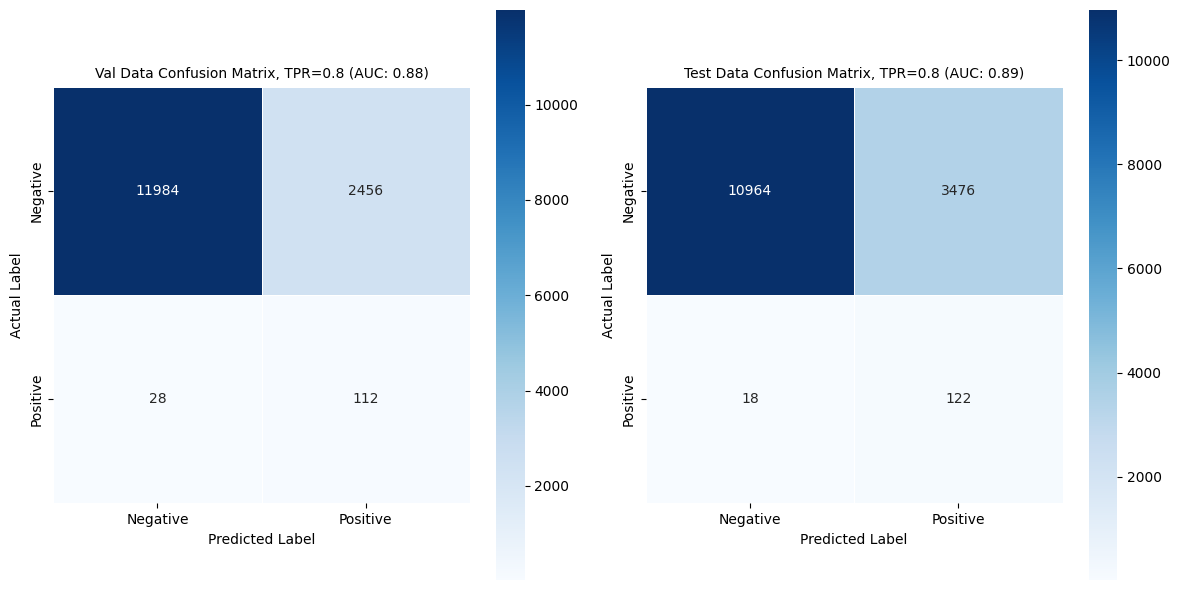

	- FPR Target: 0.05
		- Validation Accuracy: 0.9455418381344307
		- Validation Specificity: 0.949584487534626
		- Test Accuracy: 0.9460219478737997
		- Test Specificity: 0.9510387811634349


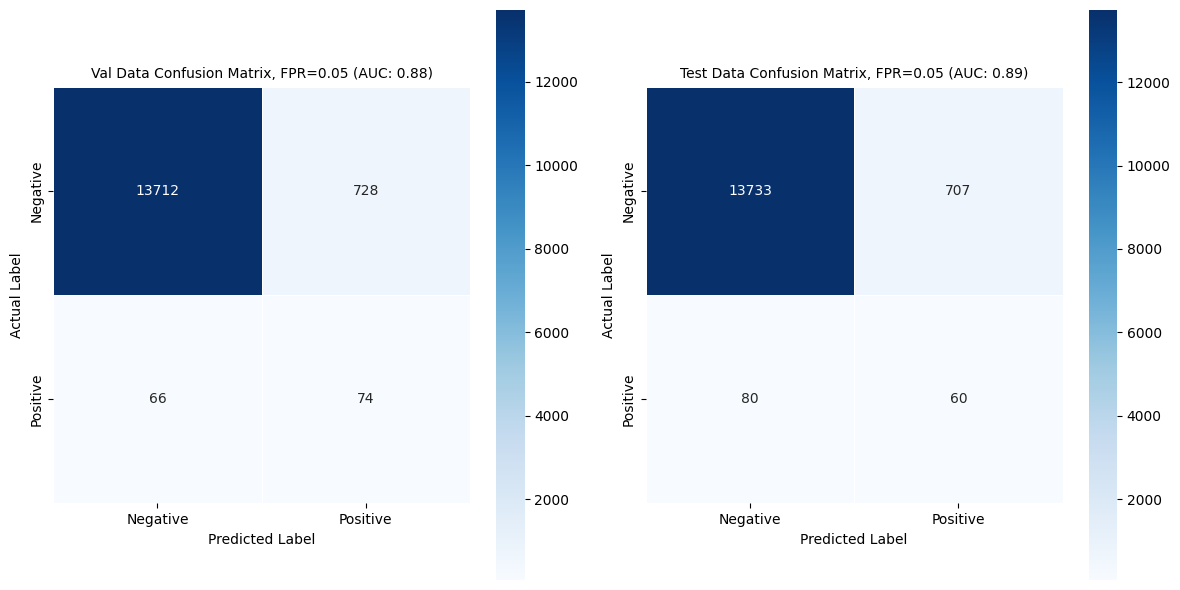

--------------------------------------------------
*experiment_idx = 1
- 73,000 total rows in features dict.
- 73,000 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it]


	- Best Val AUC Epoch: 184
	- Best Val AUC: 0.9638852983598288
	- Best Test AUC: 0.9560870587147814
	- TPR Target: 0.8
		- Validation Accuracy: 0.9325102880658436
		- Validation Recall: 0.7992957746478874
		- Test Accuracy: 0.9755829903978052
		- Test Recall: 0.5335689045936396


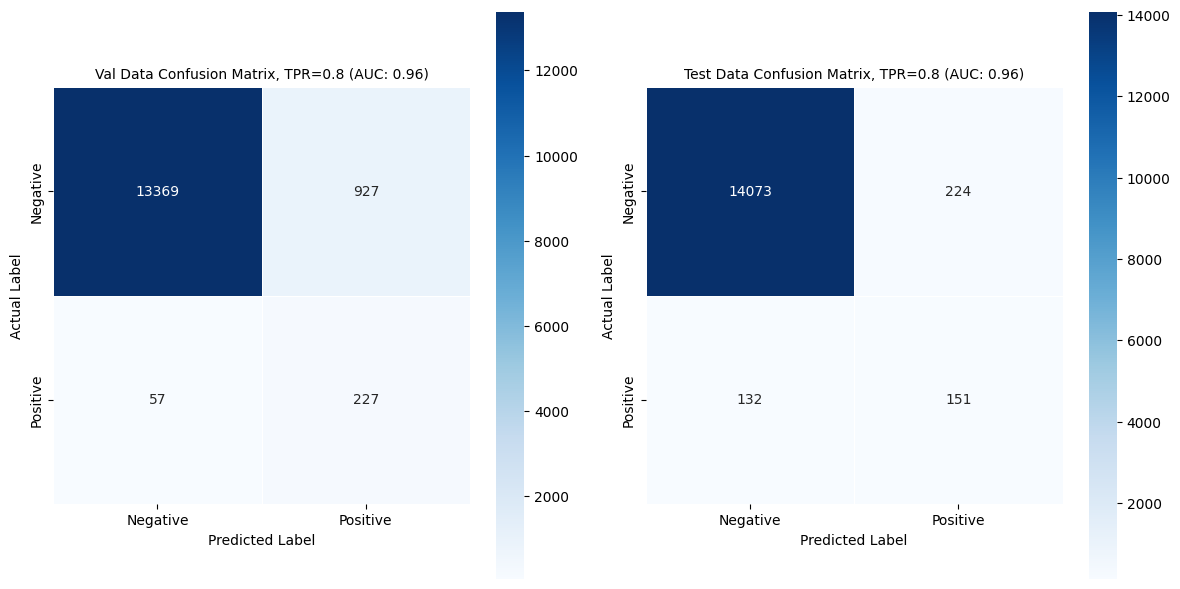

	- FPR Target: 0.05
		- Validation Accuracy: 0.9457475994513032
		- Validation Specificity: 0.9501259093452714
		- Test Accuracy: 0.980315500685871
		- Test Specificity: 0.990487514863258


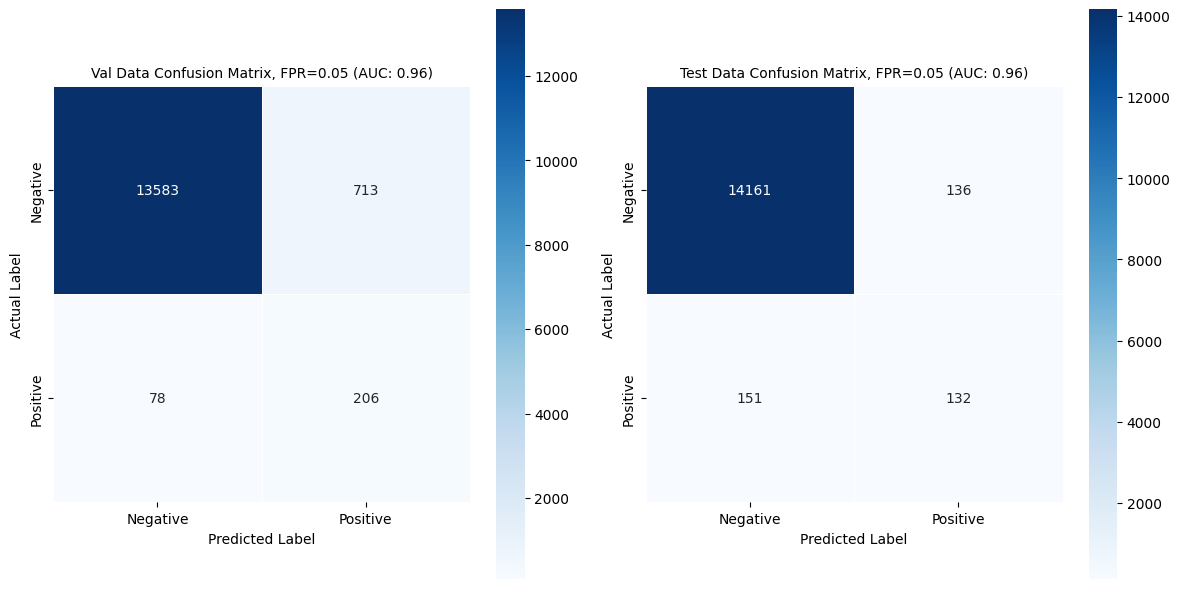

--------------------------------------------------
*experiment_idx = 2
- 36,500 total rows in features dict.
- 36,500 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


	- Best Val AUC Epoch: 164
	- Best Val AUC: 0.9984033613445379
	- Best Test AUC: 0.9956692677070829
	- TPR Target: 0.8
		- Validation Accuracy: 0.9932692307692308
		- Validation Recall: 0.8071428571428572
		- Test Accuracy: 0.989010989010989
		- Test Recall: 0.6071428571428571


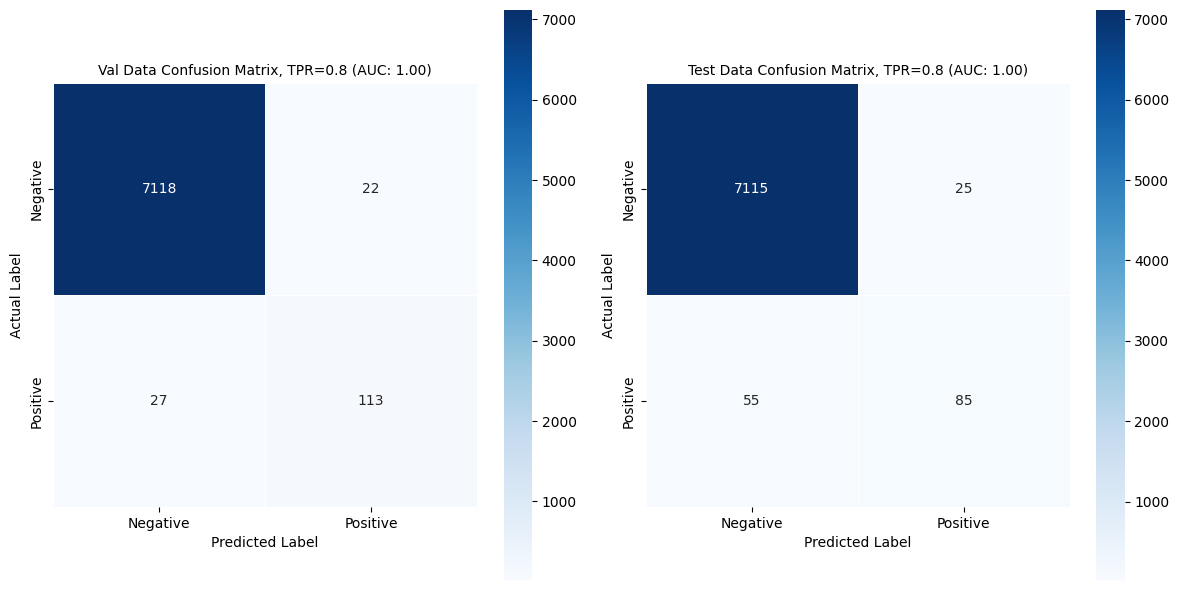

	- FPR Target: 0.05
		- Validation Accuracy: 0.9793956043956044
		- Validation Specificity: 0.9791316526610644
		- Test Accuracy: 0.9567307692307693
		- Test Specificity: 0.9561624649859944


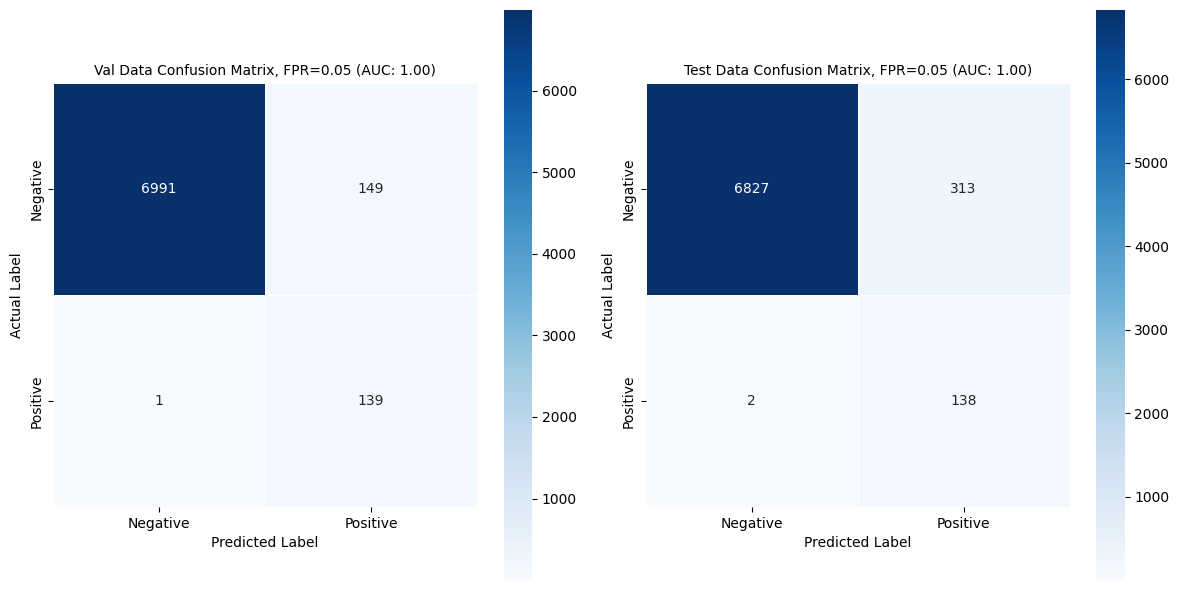

--------------------------------------------------
*experiment_idx = 3
- 36,500 total rows in features dict.
- 36,500 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


	- Best Val AUC Epoch: 193
	- Best Val AUC: 0.9986054421768708
	- Best Test AUC: 0.9965436174469787
	- TPR Target: 0.8
		- Validation Accuracy: 0.9943681318681319
		- Validation Recall: 0.8071428571428572
		- Test Accuracy: 0.9901098901098901
		- Test Recall: 0.6642857142857143


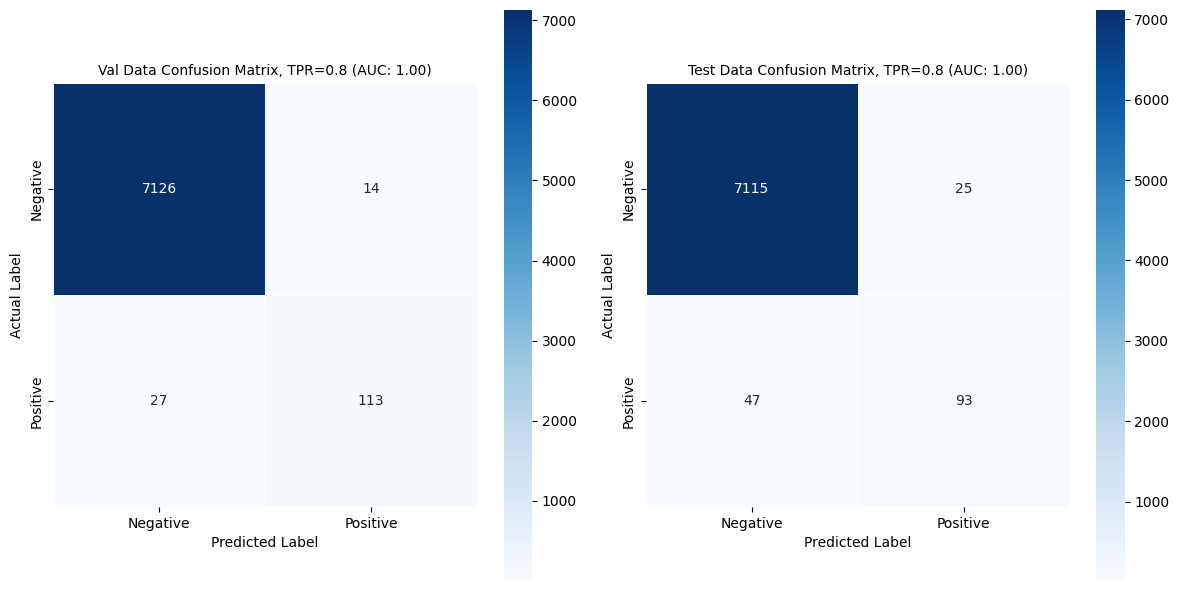

	- FPR Target: 0.05
		- Validation Accuracy: 0.9784340659340659
		- Validation Specificity: 0.9781512605042016
		- Test Accuracy: 0.9758241758241758
		- Test Specificity: 0.9756302521008403


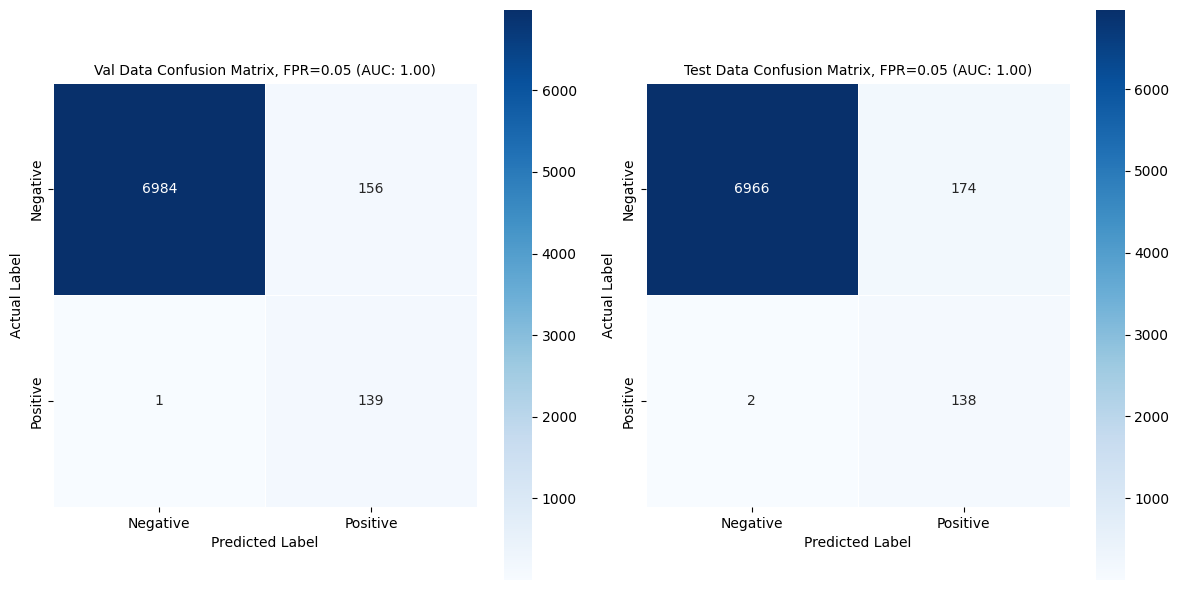

--------------------------------------------------
*experiment_idx = 4
- 18,200 total rows in features dict.
- 18,200 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


	- Best Val AUC Epoch: 198
	- Best Val AUC: 0.9982498541545128
	- Best Test AUC: 0.9979919517102616
	- TPR Target: 0.8
		- Validation Accuracy: 0.992817679558011
		- Validation Recall: 0.8028169014084507
		- Test Accuracy: 0.988950276243094
		- Test Recall: 0.9571428571428572


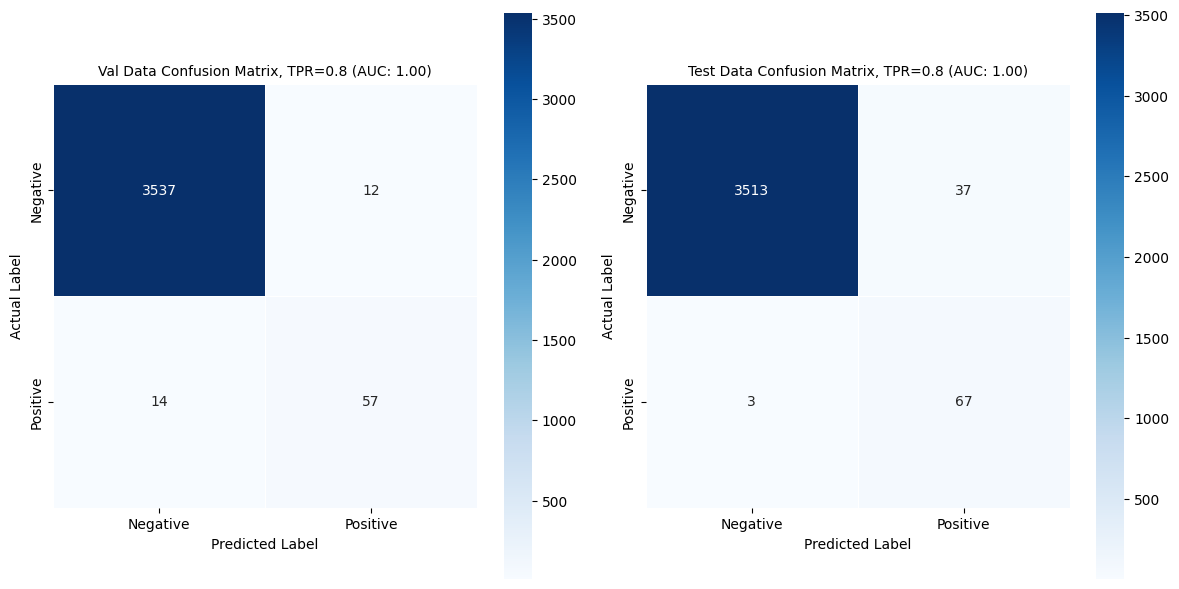

	- FPR Target: 0.05
		- Validation Accuracy: 0.9883977900552486
		- Validation Specificity: 0.9887292194984503
		- Test Accuracy: 0.9701657458563536
		- Test Specificity: 0.9698591549295774


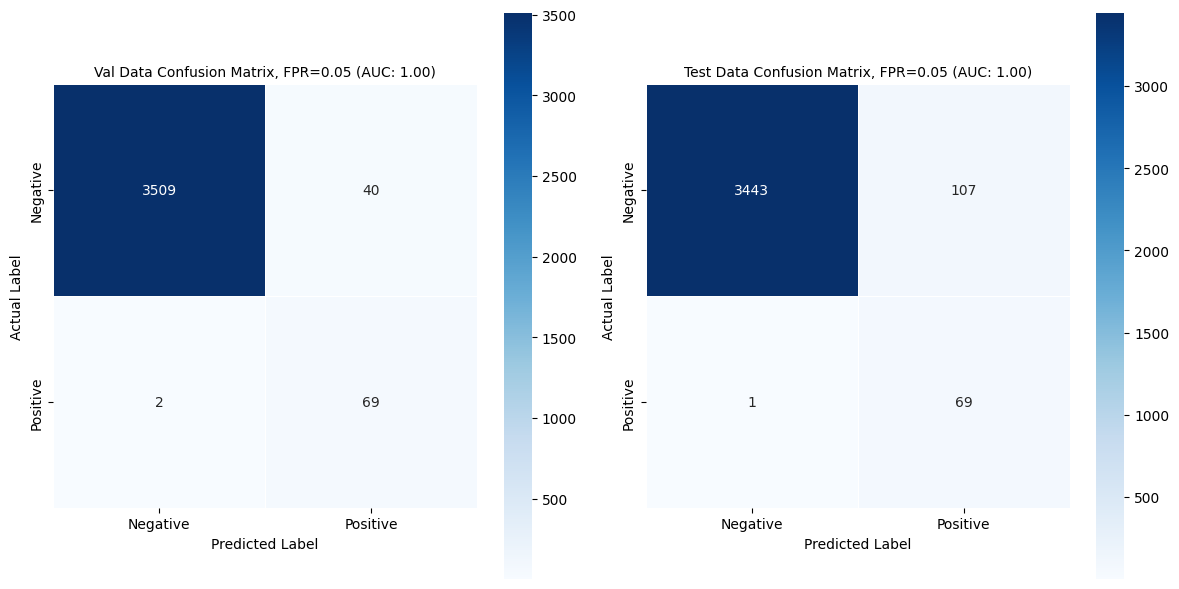

--------------------------------------------------
*experiment_idx = 5
- 18,200 total rows in features dict.
- 18,200 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [01:02<00:00,  3.20it/s]


	- Best Val AUC Epoch: 200
	- Best Val AUC: 0.9949281487743027
	- Best Test AUC: 0.9944225352112677
	- TPR Target: 0.8
		- Validation Accuracy: 0.9883977900552486
		- Validation Recall: 0.8028169014084507
		- Test Accuracy: 0.9867403314917127
		- Test Recall: 0.8428571428571429


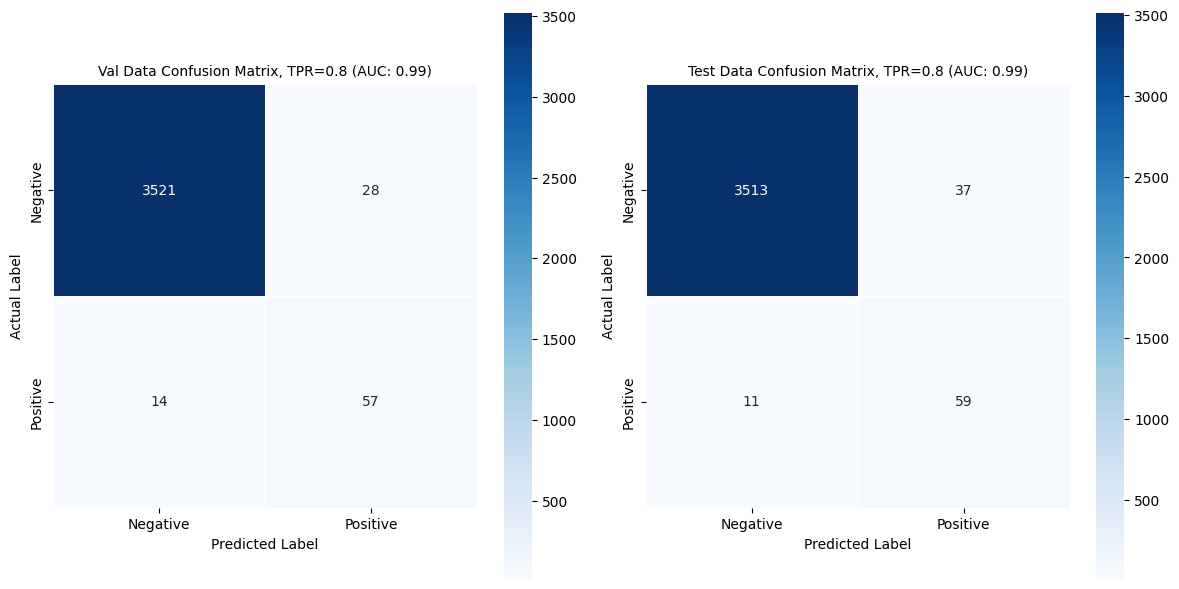

	- FPR Target: 0.05
		- Validation Accuracy: 0.9676795580110498
		- Validation Specificity: 0.9675965060580445
		- Test Accuracy: 0.9599447513812155
		- Test Specificity: 0.9594366197183098


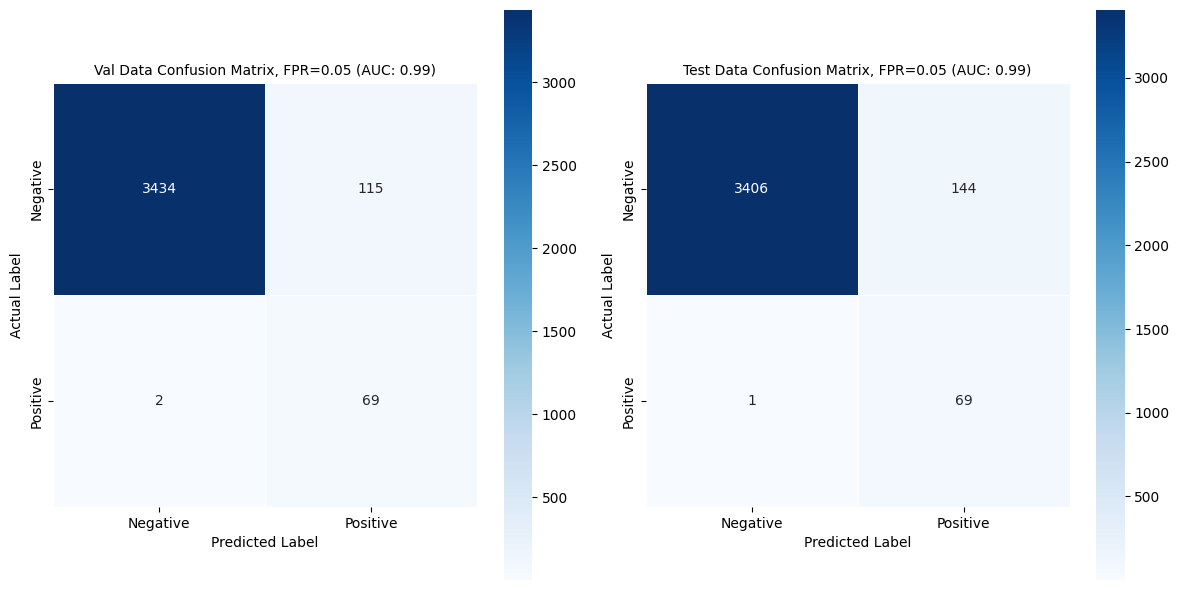

--------------------------------------------------
*experiment_idx = 6
- 12,100 total rows in features dict.
- 12,100 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


	- Best Val AUC Epoch: 169
	- Best Val AUC: 0.9819948413592768
	- Best Test AUC: 0.9907446808510638
	- TPR Target: 0.8
		- Validation Accuracy: 0.9766666666666667
		- Validation Recall: 0.803921568627451
		- Test Accuracy: 0.9791666666666666
		- Test Recall: 0.0


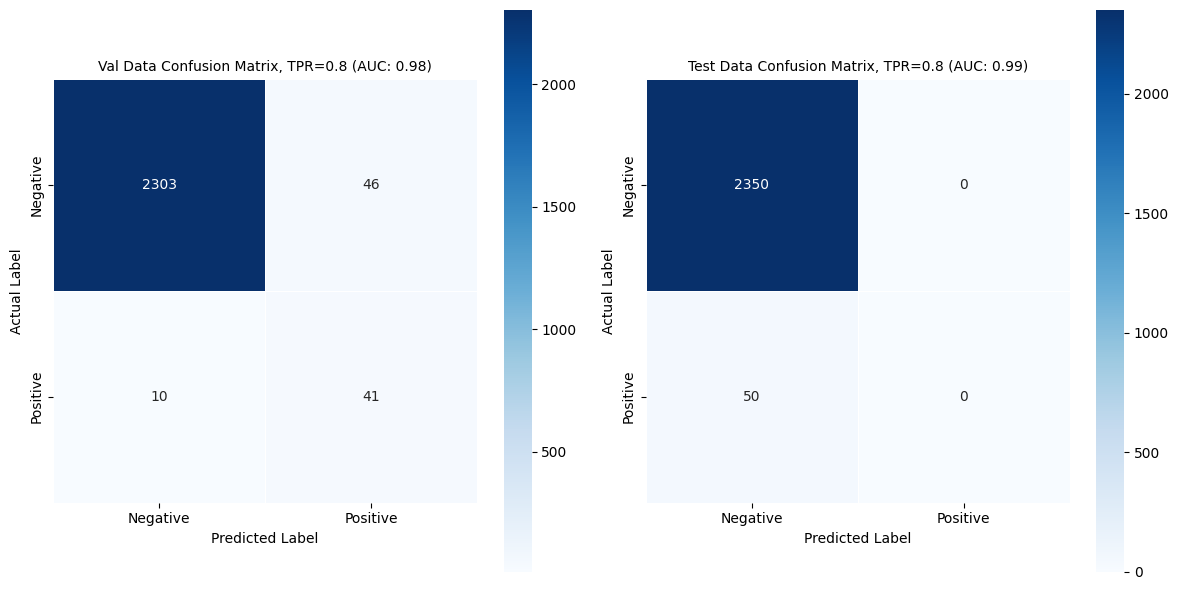

	- FPR Target: 0.05
		- Validation Accuracy: 0.945
		- Validation Specificity: 0.9455087271179226
		- Test Accuracy: 0.9858333333333333
		- Test Specificity: 0.9927659574468085


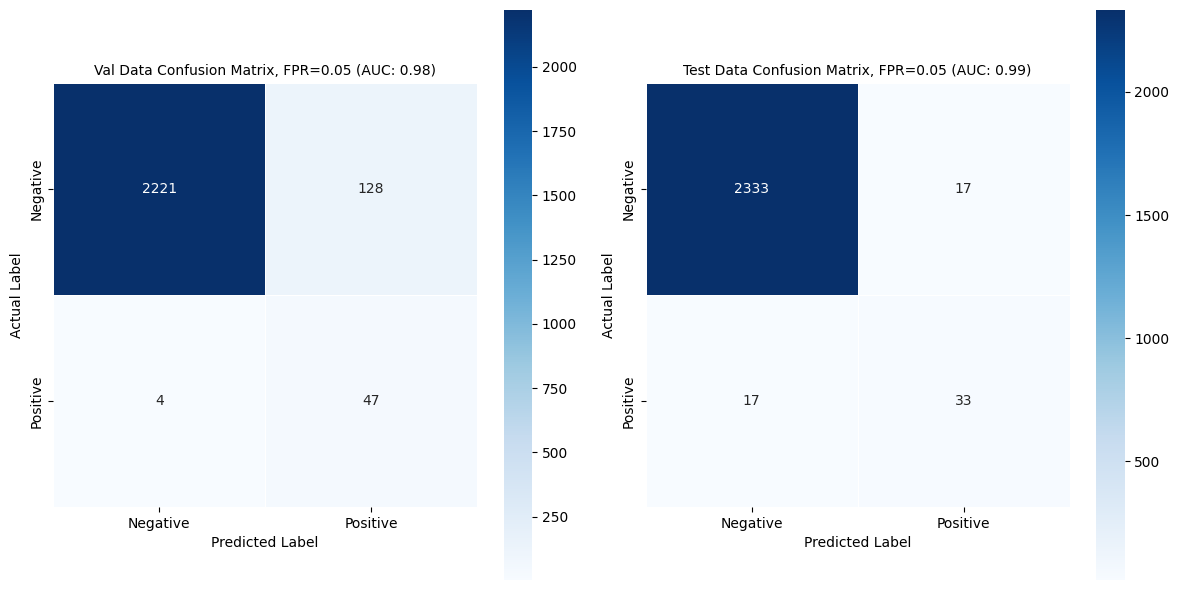

--------------------------------------------------
*experiment_idx = 7
- 12,100 total rows in features dict.
- 12,100 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [00:46<00:00,  4.27it/s]


	- Best Val AUC Epoch: 186
	- Best Val AUC: 0.9819697994140184
	- Best Test AUC: 0.9917872340425532
	- TPR Target: 0.8
		- Validation Accuracy: 0.9716666666666667
		- Validation Recall: 0.803921568627451
		- Test Accuracy: 0.9875
		- Test Recall: 0.78


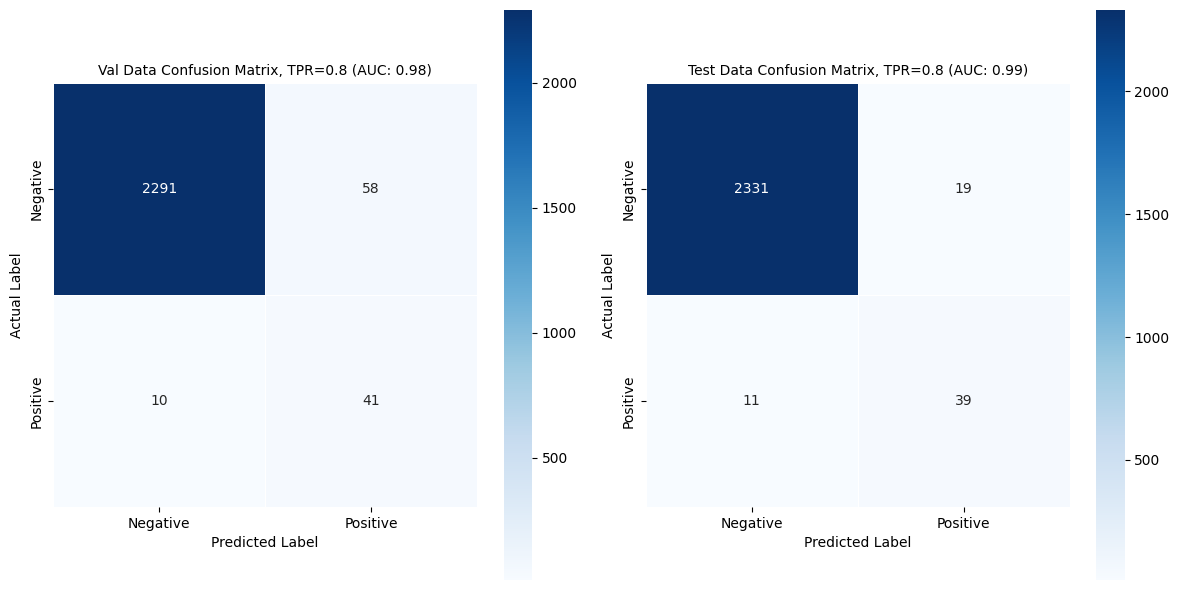

	- FPR Target: 0.05
		- Validation Accuracy: 0.95
		- Validation Specificity: 0.9510429970200085
		- Test Accuracy: 0.97875
		- Test Specificity: 0.9808510638297873


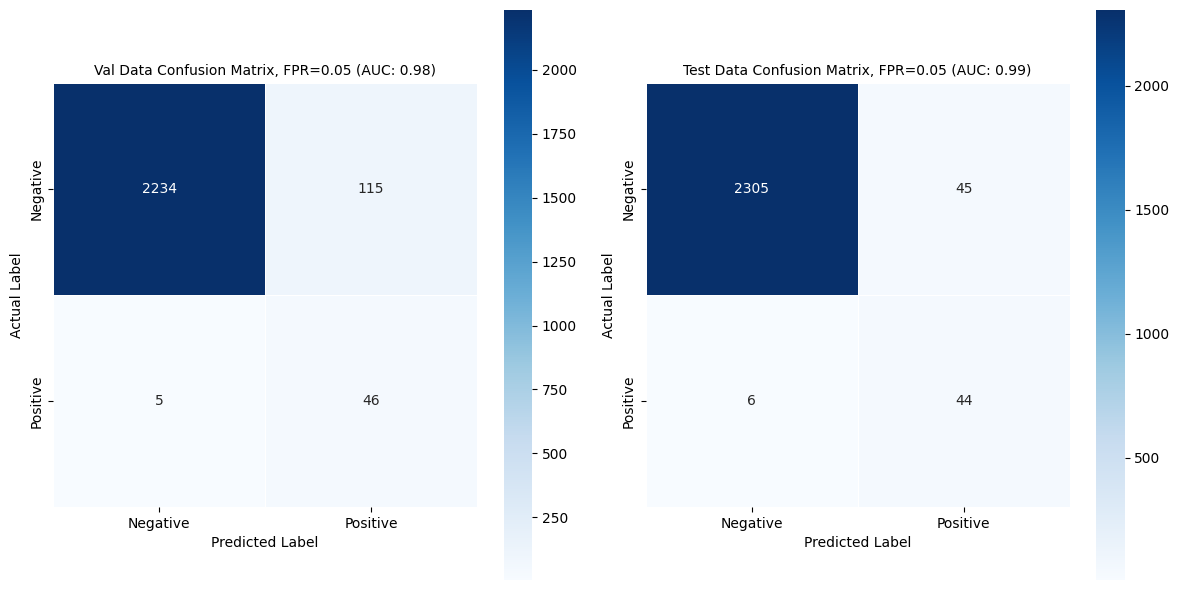

In [ ]:
for experiment_idx, experiment_dict in hyperparameters_dict.items():
    print("-" * 50)
    print(f"*experiment_idx = {experiment_idx}")

    # get hyperparams from experiment_dict
    learning_rate = experiment_dict['learning_rate']

    # load data from file paths
    X_dict, y_dict = load_data(DATA_DIR, experiment_dict['features_file'], experiment_dict['targets_file'])

    # get overlap of keys of dictionaries
    keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
    X_dict = {
        k: v for k, v in X_dict.items()
        if k in keys_set
    }
    y_dict = {
        k: v for k, v in y_dict.items()
        if k in keys_set
    }

    # convert each value in y_dict to a list
    y_dict = {
        k: [v] for k, v in y_dict.items()
    }

    # make MLP model
    model = make_mlp(
        input_dim = 45,
        hidden_dims = experiment_dict['mlp_layers'],
        output_dim = 1,
        hidden_activation = nn.ReLU,
        dropout = 0.0
    )

    # instantiate loss function
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # instantiate optimizer
    optimizer = optim.Adam(
        params = model.parameters(),
        lr = learning_rate,
        weight_decay = WEIGHT_DECAY
    )

    # split dictionaries into train-val-test arrays
    (
        X_train, X_val, X_test,
        y_train, y_val, y_test
    ) = get_train_val_test_arrays(
        X = X_dict,
        y = y_dict
    )

    # convert arrays to tensors
    X_train = torch.tensor(X_train, dtype = torch.float32)
    X_val = torch.tensor(X_val, dtype = torch.float32)
    X_test = torch.tensor(X_test, dtype = torch.float32)
    y_train = torch.tensor(y_train, dtype = torch.float32)
    y_val = torch.tensor(y_val, dtype = torch.float32)
    y_test = torch.tensor(y_test, dtype = torch.float32)

    # make Datasets
    train_dataset = get_tensordataset(
        X = X_train,
        y = y_train
    )
    val_dataset = get_tensordataset(
        X = X_val,
        y = y_val
    )
    test_dataset = get_tensordataset(
        X = X_test,
        y = y_test
    )

    # make DataLoaders
    train_loader = get_dataloader(
        dataset = train_dataset,
        shuffle = True
    )
    val_loader = get_dataloader(
        dataset = val_dataset,
        shuffle = False
    )
    test_loader = get_dataloader(
        dataset = test_dataset,
        shuffle = False
    )

    # train-val-test
    (
        best_val_auc_idx,
        best_val_y_true_list, best_val_y_hat_list,
        associated_test_y_true_list, associated_test_y_hat_list
    ) = train_validate_test(
            model = model,
            train_loader = train_loader,
            val_loader = val_loader,
            test_loader = test_loader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = torch.device('cpu'),
            epochs = 200
    )

    # compute metrics of interest
    best_val_auc = roc_auc_score(
        y_true = best_val_y_true_list,
        y_score = best_val_y_hat_list
    )
    best_test_auc = roc_auc_score(
        y_true = associated_test_y_true_list,
        y_score = associated_test_y_hat_list
    )

    # print metrics of interest
    print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
    print(f"\t- Best Val AUC: {best_val_auc}")
    print(f"\t- Best Test AUC: {best_test_auc}")

    # evaluate thresholds
    evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)